<a href="https://colab.research.google.com/github/noviaputri/Deteksi_Cyberbullying/blob/main/Fix_Penelitian_Sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import nltk
nltk.download('punkt')
from nltk import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

!pip install pycm

from pycm import ConfusionMatrix
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas import read_excel, read_csv
from sklearn import svm
from sklearn import metrics
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.1 MB/s 
     |████████████████████████████████| 592 kB 17.9 MB/s 


# Dataset

In [ ]:
#menampilkan dataset
dataset = pd.read_csv("dataset_instagram.csv")
dataset.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [ ]:
#menghapus kolom id, mengubah nama kolom, dan mengubah jenis nilai sentimen
dataset = dataset.drop(columns=['Id'])
dataset.rename(columns = {'Sentiment':'Sentimen', 'Instagram Comment Text':'Komentar Instagram'}, inplace = True)
#dataset["Sentimen"] = np.where(dataset["Sentimen"] == "positive", 1, 0)
dataset.head()

,Sentimen,Komentar Instagram
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


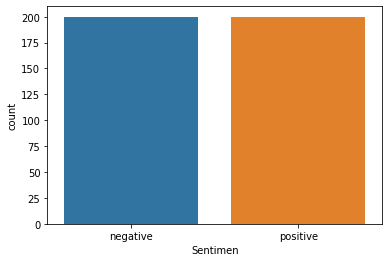

In [ ]:
# count plot on single categorical variable
sns.countplot(x ='Sentimen', data = dataset)
# show the plot
plt.show()

# Preprocessing

## 1. Case Folding / Cleaning

In [ ]:
def casefolding(text):
    # lowercase
    text = text.lower()
    # menghapus tab, baris baru, dan backslash
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\'," ")
    # menghapus non ASCII (emotikon, chinese word, dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # menghapus mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # menghapus incomplete URL
    text= text.replace("http://", " ").replace("https://", " ")
    # menghapus username
    text = re.sub('username',' ',text)
    # menghapus angka
    text = re.sub(r"\d+"," ", text)
    # menghapus tanda baca
    text = re.sub(r'[^\w\s]',' ', text)
    # menghapus spasi
    text = text.strip()
    # menghapus beberapa spasi menjadi spasi tunggal
    text = re.sub('\s+',' ',text)
    return text

dataset['Hasil Casefolding'] = dataset['Komentar Instagram'].apply(casefolding)
dataset.head()

,Sentimen,Komentar Instagram,Hasil Casefolding
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak ada hubungan nya keguguran dgn pake ...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibela in balikan hade...
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lg sakit jiwa knp harus...


## 2. Tokenisasi

In [ ]:
# membuat fungsi untuk proses tokenisasi
def tokens(text):
  hasil_tokens = nltk.tokenize.word_tokenize(text)
  return hasil_tokens

dataset['Hasil Tokenisasi'] = dataset['Hasil Casefolding'].apply(tokens)
dataset.head()

,Sentimen,Komentar Instagram,Hasil Casefolding,Hasil Tokenisasi
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak ada hubungan nya keguguran dgn pake ...,"[tolol, gak, ada, hubungan, nya, keguguran, dg..."
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibela in balikan hade...,"[geblek, lo, tata, cowo, bgt, dibela, in, bali..."
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...,"[kmrn, termewek, skr, lengket, lg, duhhh, kok,..."
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...,"[intinya, kalau, kesel, dengan, att, nya, gaus..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lg sakit jiwa knp harus...,"[hadewwwww, permpuan, itu, lg, sakit, jiwa, kn..."


## 3. Normalisasi

In [ ]:
# membuat kamus kata normalisasi dalam bentuk dictionary
normalized_word = pd.read_excel("kamus kata normalisasi.xlsx")
normalized_word_dict = {}
for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

# membuat fungsi untuk proses normalisasi
def normalize_text(data):
    word_result = []
    for w in data:
      hasil = normalized_word_dict.get(w, w)
      word_result.append(hasil)
    text_result = " ".join(word_result)
    result = nltk.tokenize.word_tokenize(text_result)
    return result

dataset['Hasil Normalisasi'] = dataset['Hasil Tokenisasi'].apply(lambda x: normalize_text(x))
dataset.head()

,Sentimen,Komentar Instagram,Hasil Casefolding,Hasil Tokenisasi,Hasil Normalisasi
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak ada hubungan nya keguguran dgn pake ...,"[tolol, gak, ada, hubungan, nya, keguguran, dg...","[tolol, tidak, ada, hubungan, nya, keguguran, ..."
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibela in balikan hade...,"[geblek, lo, tata, cowo, bgt, dibela, in, bali...","[bodoh, sekali, kamu, tata, cowok, banget, dib..."
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...,"[kmrn, termewek, skr, lengket, lg, duhhh, kok,...","[kemarin, termewek, sekarang, lengket, lagi, a..."
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...,"[intinya, kalau, kesel, dengan, att, nya, gaus...","[intinya, kalau, kesal, dengan, ayu, ting, tin..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lg sakit jiwa knp harus...,"[hadewwwww, permpuan, itu, lg, sakit, jiwa, kn...","[aduh, perempuan, itu, lagi, sakit, jiwa, kena..."


## 4. Filtering

In [ ]:
# membuat list untuk stopwords bahasa indonesia dari library nltk
list_stopwords_original = list(stopwords.words('indonesian'))
print("Jumlah stopwords indonesia : ", len(list_stopwords_original))

Jumlah stopwords indonesia :  758


In [ ]:
# membuat list untuk semua kata dan karakter yang terdapat di dalam leksikon
list_negatingwords = [line.replace('\n','') for line in open("negatingword.txt").read().splitlines()]
list_questionwords = [line.replace('\n','') for line in open("questionword.txt").read().splitlines()]
list_sentiwords = [line.replace('\n','').split(":")[0] for line in open("sentiwords_id.txt").read().splitlines()]
list_boosterwords = [line.replace('\n','').split(":")[0] for line in open("boosterwords_id.txt").read().splitlines()]
list_idiomwords = [line.replace('\n','').split(":")[0] for line in open("idioms_id.txt").read().splitlines()]
list_emoticons = [line.replace('\n','').split("|")[0] for line in open("emoticon_id.txt").read().splitlines()]
all_words = list_negatingwords + list_questionwords + list_sentiwords + list_boosterwords + list_idiomwords + list_emoticons

In [ ]:
# membuat list untuk stopwords yang akan digunakan setelah dikurangkan dengan kata yang terdapat di kamus leksikon
list_stopwords = []
for word in list_stopwords_original:
  if word not in all_words :
    hasil = word
    list_stopwords.append(hasil)
print("Jumlah stopwords yang digunakan : ", len(list_stopwords))

Jumlah stopwords yang digunakan :  673


In [ ]:
# membuat fungsi untuk menghapus stopwords
def stopwords_removal(data):
    result = []
    for word in data:
      if word not in list_stopwords :
        hasil = word
        result.append(hasil)
    return result

dataset['Hasil Filtering'] = dataset['Hasil Normalisasi'].apply(stopwords_removal)
dataset.head()

,Sentimen,Komentar Instagram,Hasil Casefolding,Hasil Tokenisasi,Hasil Normalisasi,Hasil Filtering
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak ada hubungan nya keguguran dgn pake ...,"[tolol, gak, ada, hubungan, nya, keguguran, dg...","[tolol, tidak, ada, hubungan, nya, keguguran, ...","[tolol, tidak, hubungan, nya, keguguran, pakai..."
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibela in balikan hade...,"[geblek, lo, tata, cowo, bgt, dibela, in, bali...","[bodoh, sekali, kamu, tata, cowok, banget, dib...","[bodoh, sekali, tata, cowok, banget, dibela, i..."
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...,"[kmrn, termewek, skr, lengket, lg, duhhh, kok,...","[kemarin, termewek, sekarang, lengket, lagi, a...","[kemarin, termewek, lengket, aduh, kok, labil,..."
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...,"[intinya, kalau, kesel, dengan, att, nya, gaus...","[intinya, kalau, kesal, dengan, ayu, ting, tin...","[intinya, kesal, ayu, ting, ting, nya, tidak, ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lg sakit jiwa knp harus...,"[hadewwwww, permpuan, itu, lg, sakit, jiwa, kn...","[aduh, perempuan, itu, lagi, sakit, jiwa, kena...","[aduh, perempuan, sakit, jiwa, kenapa, peran, ..."


## Stemming

In [ ]:
# membuat fungsi untuk proses stemming
def stemming(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  resultt = []
  for word in data:
    hasil = stemmer.stem(word)
    resultt.append(hasil)
  result = " ".join(resultt)
  return result

dataset['Hasil Stemming'] = dataset['Hasil Filtering'].apply(stemming)
dataset.head()

,Sentimen,Komentar Instagram,Hasil Casefolding,Hasil Tokenisasi,Hasil Normalisasi,Hasil Filtering,Hasil Stemming
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol gak ada hubungan nya keguguran dgn pake ...,"[tolol, gak, ada, hubungan, nya, keguguran, dg...","[tolol, tidak, ada, hubungan, nya, keguguran, ...","[tolol, tidak, hubungan, nya, keguguran, pakai...",tolol tidak hubung nya gugur pakai hijab syar ...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata cowo bgt dibela in balikan hade...,"[geblek, lo, tata, cowo, bgt, dibela, in, bali...","[bodoh, sekali, kamu, tata, cowok, banget, dib...","[bodoh, sekali, tata, cowok, banget, dibela, i...",bodoh sekali tata cowok banget bela in balik a...
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...,"[kmrn, termewek, skr, lengket, lg, duhhh, kok,...","[kemarin, termewek, sekarang, lengket, lagi, a...","[kemarin, termewek, lengket, aduh, kok, labil,...",kemarin mewek lengket aduh kok labil banget si...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...,"[intinya, kalau, kesel, dengan, att, nya, gaus...","[intinya, kalau, kesal, dengan, ayu, ting, tin...","[intinya, kesal, ayu, ting, ting, nya, tidak, ...",inti kesal ayu ting ting nya tidak anak kasiha...
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lg sakit jiwa knp harus...,"[hadewwwww, permpuan, itu, lg, sakit, jiwa, kn...","[aduh, perempuan, itu, lagi, sakit, jiwa, kena...","[aduh, perempuan, sakit, jiwa, kenapa, peran, ...",aduh perempuan sakit jiwa kenapa peran utama f...


In [ ]:
dataset.to_csv('hasil_preprocessing_fix.csv', index=False)

# Pelabelan SentiStrength

In [ ]:
class sentistrength:
    def __init__(self, config=dict()):
        # membuat list kata negasi
        self.negasi = [line.replace('\n','') for line in open("negatingword.txt").read().splitlines()]
        # membuat list kata tanya
        self.tanya = [line.replace('\n','') for line in open("questionword.txt").read().splitlines()]
        # membuat kamus kata bersentimen
        self.sentiwords_txt = [line.replace('\n','').split(":") for line in open("sentiwords_id.txt").read().splitlines()]
        self.sentiwords_dict = OrderedDict()
        for term in self.sentiwords_txt:
            self.sentiwords_dict[term[0]] = int(term[1])
        # membuat kamus emotikon
        self.emoticon_txt = [line.replace('\n','').split(" | ") for line in open("emoticon_id.txt").read().splitlines()]
        self.emoticon_dict = OrderedDict()
        for term in self.emoticon_txt:
            self.emoticon_dict[term[0]] = int(term[1])
        # membuat kamus idiom
        self.idioms_txt = [line.replace('\n','').split(":") for line in open("idioms_id.txt").read().splitlines()]
        self.idioms_dict = OrderedDict()
        for term in self.idioms_txt:
            self.idioms_dict[term[0]] = int(term[1])
        # membuat kamus kata booster
        self.boosterwords_txt = [line.replace('\n','').split(":") for line in open("boosterwords_id.txt").read().splitlines()]
        self.boosterwords_dict = OrderedDict()
        for term in self.boosterwords_txt:
            self.boosterwords_dict[term[0]] = int(term[1])
        self.negation_conf = config["negation"]
        self.booster_conf = config["booster"]
        self.ungkapan_conf = config["ungkapan"]
        self.consecutive_conf = config["consecutive"]
        self.repeated_conf = config["repeated"]
        self.emoticon_conf = config["emoticon"]
        self.question_conf = config["question"]
        self.exclamation_conf = config["exclamation"]
        self.punctuation_conf = config["punctuation"]
        self.mean_conf = True

    # membuat fungsi untuk mendapatkan nilai sentimen dari kata bersentimen
    def senti(self,term):
        try:
            return self.sentiwords_dict[term]
        except:
            return 0

    # membuat fungsi untuk mendapatkan nilai sentimen dari emotikon
    def emosikon(self,term):
        try:
            return self.emoticon_dict[term]
        except:
            return 0

    # membuat fungsi untuk mendapatkan nilai sentimen dari kata ungkapan
    def ungkapan(self,term):
        try:
            return self.idioms_dict[term]
        except:
            return 0

    # membuat fungsi untuk mendapatkan nilai sentimen dari kata booster
    def booster(self, term):
        try:
            return self.boosterwords_dict[term]
        except:
            return 0

    # membuat fungsi untuk mengecek apakah terdapat kata negasi
    def cek_negationword(self, prev_term, prev_term2):
        #jika kata sebelumnya (index-1) adalah kata negasi, negasikan nilai -+nya
        if prev_term in self.negasi or prev_term2+" "+prev_term in self.negasi:
            self.score = -abs(self.score) if self.score>0 else abs(self.score)

    # membuat fungsi untuk mengecek apakah terdapat kata booster
    def cek_boosterword(self,term):
        booster_score = self.booster(term)
        if booster_score !=0 and self.score>0: self.score += booster_score
        if booster_score !=0 and self.score<0: self.score -= booster_score

    # membuat fungsi untuk mengecek kata berurutan
    def cek_consecutive_term(self, prev_term):
        if self.prev_score>0 and self.score >=3: self.score+=1
        if self.prev_score<0 and self.score <=-3: self.score-=1

    # membuat fungsi untuk mengecek ungkapan
    def cek_ungkapan(self, bigram,trigram, i):
        bigram = ' '.join(bigram)
        trigram = ' '.join(trigram)
        ungkapan_score = self.ungkapan(bigram)
        if ungkapan_score==0:
            ungkapan_score = self.ungkapan(trigram)
        if ungkapan_score!=0:
            self.score = ungkapan_score
            self.prev_score = 0
            self.pre_max_pos[i-1] = 1
            self.pre_max_neg[i-1] = -1
            self.max_pos = self.pre_max_pos[i-2]
            self.max_neg = self.pre_max_neg[i-2]
            self.sentence_score[i-1] = re.sub(r'\[\d\]','',self.sentence_score[i-1])

    # membuat fungsi untuk mengecek tanda baca yang berulang
    def cek_repeated_punctuation(self, next_term):
        if re.search(r'!{2,}',next_term) and self.score >=3: self.score+=1
        if re.search(r'!{2,}',next_term) and self.score <=-3: self.score-=1

    # membuat fungsi untuk menghapus karakter yang berulang
    def remove_extra_repeated_char(self, term):
        return re.sub(r'([A-Za-z])\1{2,}',r'\1',term)

    # membuat fungsi untuk mengubah kata ulang
    def plural_to_singular(self, term):
        return re.sub(r'([A-Za-z]+)\-\1', r'\1',term)

    # membuat fungsi untuk mengklasifikasikan jenis sentimen
    def classify(self):
        self.jumlah_pos = sum(self.mean_pos)
        self.jumlah_neg = -(sum(self.mean_neg))
        try:
            if abs(self.sentences_max_pos) > abs(self.sentences_max_neg):
                result = "positive"
            elif abs(self.sentences_max_pos) < abs(self.sentences_max_neg):
                result = "negative"
            else:
                result = "positive"
        except:
            print("error ",self.sentences_max_pos, self.sentences_max_neg)
        return result

    # membuat fungsi untuk mengecek kata netral
    def cek_neutral_term(self,terms,i):
        if terms[i-1] in self.neutral_term or terms[i+1] in self.neutral_term: self.score=1

    def main(self,sentence):
        self.neutral_term = ['jika','kalau']
        sentences = sentence.split('.')
        self.sentences_max_neg = 0
        self.sentences_max_pos = 0
        self.sentences_score = []
        self.sentences_text = []
        for sentence in sentences:
            self.max_neg = 0
            self.max_pos = 0
            self.mean_neg = []
            self.mean_pos = []
            self.sentence_score=[]
            terms = sentence.split()
            terms_length = len(terms)
            self.is_tanya = False
            self.sentence_text = ''

            #SEMUA KALIMAT YANG MEMILIKI TANDA SERU MEMILIKI +ve minimal 2
            if self.exclamation_conf and re.search('!',sentence): self.max_pos = 2
            self.prev_score = 0
            self.pre_max_pos = []
            self.pre_max_neg = []
            for i,term in enumerate(terms):
                is_extra_char = False
                plural = ''
                self.score = 0
                if re.search(r'([A-Za-z])\1{3,}',term):
                    is_extra_char = True
                term = self.remove_extra_repeated_char(term)
                if re.search(r'([A-Za-z]+)\-\1',term):
                    plural = term
                    term = self.plural_to_singular(term)

                #GET SENTI SCORE#
                self.score = self.senti(term)

                #NEGATION HANDLER#
                if self.negation_conf and self.score !=0 and i>0:self.cek_negationword(terms[i-1],terms[i-2])

                #BOOSTERWORD HANDLER#
                if self.booster_conf and self.score !=0 and i>0 and i<=(terms_length-1):self.cek_boosterword(terms[i-1])
                if self.booster_conf and self.score !=0 and i>=0 and i<(terms_length-1):self.cek_boosterword(terms[i+1])

                #IDIOM/UNGKAPAN HANDLER#
                if self.ungkapan_conf and i>0 and i<=(terms_length-1):self.cek_ungkapan([terms[i-1],term],[terms[i-2],terms[i-1],term],i)

                #CONSECUTIVE SENTIMENT WORD#
                if self.consecutive_conf and i>0 and i<=(terms_length-1) and self.score !=0:self.cek_consecutive_term(terms[i-1])

                #+1 SENTI SCORE IF REPEATED CHAR ON POSITIVE/NEGATIVE +2 IF NEUTRAL TERM
                if self.repeated_conf and is_extra_char==True and self.score>0: self.score+=1
                if self.repeated_conf and is_extra_char==True and self.score<0: self.score-=1
                if self.repeated_conf and is_extra_char==True and self.score==0: self.score=2
                if self.punctuation_conf and i>=0 and i<(terms_length-1): self.cek_repeated_punctuation(terms[i+1])

                # CEK APAKAH TERDAPAT KATA TANYA
                if self.question_conf and (term in self.tanya or re.search(r'\?',term)):self.is_tanya = True

                # CEK NEUTRAL TERM
                if self.score!=0 and i>1 and i<(terms_length-2): self.cek_neutral_term(terms,i)
                if self.emoticon_conf and self.score==0: self.score = self.emosikon(term)

                self.prev_score = self.score
                if self.mean_conf and self.score>0: self.mean_pos.append(self.score)
                if self.mean_conf and self.score<0: self.mean_neg.append(abs(self.score))

                #GET MAX SCORE +ve/-ve
                self.max_pos= self.score if self.score > self.max_pos else self.max_pos
                self.max_neg= self.score if self.score < self.max_neg else self.max_neg
                #insert score info current term
                self.pre_max_pos.append(self.max_pos)
                self.pre_max_neg.append(self.max_neg)
                if plural !='': term = plural
                self.sentence_text += ' {}'.format(term)
                if self.score != 0:term = "{} [{}]".format(term, self.score)
                self.sentence_score.append(term)

            self.sentences_text.append(self.sentence_text)
            self.sentences_score.append(" ".join(self.sentence_score))
            if self.is_tanya:
                self.max_neg = -1
            self.sentences_max_pos = self.max_pos if self.max_pos > self.sentences_max_pos else self.sentences_max_pos
            self.sentences_max_neg = self.max_neg if self.max_neg < self.sentences_max_neg else self.sentences_max_neg
        sentence_result = self.classify()
        max_pos = self.sentences_max_pos
        max_neg = self.sentences_max_neg
        sum_pos = self.jumlah_pos
        sum_neg = self.jumlah_neg
        return sentence_result, max_pos, max_neg, sum_pos, sum_neg

config = dict()
config["negation"] = True
config["booster"]  = True
config["ungkapan"]  = True
config["consecutive"]  = True
config["repeated"]  = True
config["emoticon"]  = True
config["question"]  = True
config["exclamation"]  = True
config["punctuation"]  = True
senti = sentistrength(config)

In [ ]:
# membuat variabel list untuk menampung hasil pelabelan sentistrength
hasil = []
# melakukan perulangan untuk menerapkan proses pelabelan ke dalam data hasil stemming
for x in dataset["Hasil Stemming"]:
  hasil.append(senti.main(x))
# menampilkan 10 hasil teratas
hasil[:10]

[('negative', 0, -5, 0, -5),
 ('negative', 0, -5, 0, -13),
 ('negative', 4, -6, 5, -12),
 ('negative', 5, -6, 13, -27),
 ('positive', 1, -1, 1, -6),
 ('positive', 4, 0, 8, 0),
 ('positive', 5, -4, 15, -23),
 ('positive', 5, -5, 18, -21),
 ('negative', 4, -5, 4, -5),
 ('negative', 0, -5, 0, -9)]

In [ ]:
# mengambil data label hasil prediksi dan mengubah nilainya menjadi numerik
hasil_prediksi = {'predict_label': [item[0] for item in hasil]}
df_hasilprediksi = pd.DataFrame(hasil_prediksi)
#df_hasilprediksi["predict_label"] = np.where(df_hasilprediksi["predict_label"] == "negative", 0, 1)

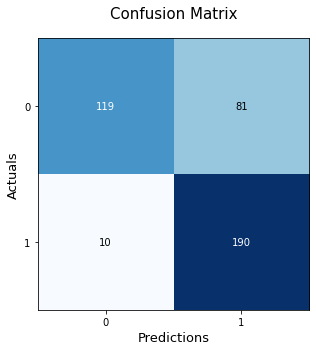


Classification Report = 
              precision    recall  f1-score   support

    negative       0.92      0.59      0.72       200
    positive       0.70      0.95      0.81       200

    accuracy                           0.77       400
   macro avg       0.81      0.77      0.77       400
weighted avg       0.81      0.77      0.77       400


f1 score :  0.7651
precision :  0.8118
recall :  0.7725
accuracy :  0.7725


In [ ]:
# menghitung performa dari hasil pelabelan menggunakan leksikon sentistrength
Y_label = dataset["Sentimen"]
predictions = df_hasilprediksi["predict_label"]

conf_matrix = confusion_matrix(Y_label, predictions)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(5, 5), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=13)
plt.ylabel('Actuals', fontsize=13)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

print("\nClassification Report = ")
print(metrics.classification_report(Y_label, predictions))

f1score = f1_score(Y_label, predictions, average = "weighted")
precision = precision_score(Y_label, predictions, average = "weighted")
recall = recall_score(Y_label, predictions, average = "weighted")
acc = accuracy_score(Y_label, predictions)
print("\nf1 score : ",round(f1score,4))
print("precision : ",round(precision,4))
print("recall : ",round(recall,4))
print("accuracy : ",round(acc,4))

# Machine Learning Classifier

## Menghitung confidence score

Rumus untuk menghitung confidence score yaitu :

[![conf-score-rumus.png](https://i.postimg.cc/3N3mwpMv/conf-score-rumus.png)](https://postimg.cc/PpFP3C5X)

In [ ]:
# membuat dataframe dengan kolom data komentar, data hasil preprocessing, label sebenarnya, label prediksi, nilai max positif, nilai max negatif, jumlah nilai positif, dan jumlah nilai negatif
datahasil = {'data komentar' : dataset["Komentar Instagram"], 'data preprocessing' : dataset["Hasil Stemming"], 'actual label' : dataset["Sentimen"],
             'predicted label': df_hasilprediksi["predict_label"], 'max_pos' : [item[1] for item in hasil], 'max_neg' : [item[2] for item in hasil],
             'sumvalue_pos' : [item[3] for item in hasil], 'sumvalue_neg' : [item[4] for item in hasil]}
df = pd.DataFrame(datahasil)
df.head()

,data komentar,data preprocessing,actual label,predicted label,max_pos,max_neg,sumvalue_pos,sumvalue_neg
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol tidak hubung nya gugur pakai hijab syar ...,negative,negative,0,-5,0,-5
1,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh sekali tata cowok banget bela in balik a...,negative,negative,0,-5,0,-13
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek lengket aduh kok labil banget si...,negative,negative,4,-6,5,-12
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesal ayu ting ting nya tidak anak kasiha...,negative,negative,5,-6,13,-27
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",aduh perempuan sakit jiwa kenapa peran utama f...,negative,positive,1,-1,1,-6


In [ ]:
# membuat variabel list untuk menampung hasil penghitungan confidence score
prediction_confidence_scores = []
# membuat fungsi untuk menghitung confidence score
def conf_score(data):
  for x in range(len(data)):
    sum_positive = data["sumvalue_pos"][x]
    sum_negative = data["sumvalue_neg"][x]
    total_score = sum_positive + sum_negative
    if total_score != 0:
      prediction_confidence_score =  float(abs(sum_positive + sum_negative)/(abs(sum_positive)+abs(sum_negative)))
    else:
      prediction_confidence_score = 0
    prediction_confidence_scores.append(prediction_confidence_score)
conf_score(df)
# menampilkan 10 hasil teratas confidence score
prediction_confidence_scores[:10]

[1.0,
 1.0,
 0.4117647058823529,
 0.35,
 0.7142857142857143,
 1.0,
 0.21052631578947367,
 0.07692307692307693,
 0.1111111111111111,
 1.0]

In [ ]:
# memasukkan data confidence score ke dalam dataframe df
df["confidence score"] = prediction_confidence_scores
df.head()

,data komentar,data preprocessing,actual label,predicted label,max_pos,max_neg,sumvalue_pos,sumvalue_neg,confidence score
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol tidak hubung nya gugur pakai hijab syar ...,negative,negative,0,-5,0,-5,1.000000
1,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh sekali tata cowok banget bela in balik a...,negative,negative,0,-5,0,-13,1.000000
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek lengket aduh kok labil banget si...,negative,negative,4,-6,5,-12,0.411765
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesal ayu ting ting nya tidak anak kasiha...,negative,negative,5,-6,13,-27,0.350000
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",aduh perempuan sakit jiwa kenapa peran utama f...,negative,positive,1,-1,1,-6,0.714286



## Membagi hasil prediksi leksikon SentiStrength

Membagi hasil prediksi leksikon SentiStrength ke dalam 5 Bin berdasarkan nilai confidence nya.
- Bin 1 dengan confidence score sangat tinggi
- Bin 2 dengan confidence score tinggi
- Bin 3 dengan confidence score rendah
- Bin 4 dengan confidence score sangat rendah
- Bin 5 dengan confidence score 0

Pembagian confidence score berdasarkan dengan aturan sebagai berikut :
[![conf-score.png](https://i.postimg.cc/HsX1myY2/conf-score.png)](https://postimg.cc/XpjzcXyG)

In [ ]:
# fungsi untuk membuat file csv untuk menyimpan hasil pembagian Bin 1, Bin 2, Bin 3, Bin 4, dan Bin 5
def write_CSV(X_data, Y_label, Y_prediction, confidence_scores ,category):
  csvfile=open("/content/bin_" + category +".csv",'w', newline='')
  obj=csv.writer(csvfile)
  data= []
  label = []
  prediction = []
  confidence = []
  for i in range(len(X_data)):
    data.append(X_data[i])
    label.append(Y_label[i])
    prediction.append( Y_prediction[i])
    confidence.append(confidence_scores[i])
  for element in zip(data, label,prediction, confidence):
    obj.writerow(element)
  csvfile.close()

In [ ]:
# fungsi untuk pembagian data hasil prediksi leksikon sentistrength ke dalam Bin 1, Bin 2, Bin 3, Bin 4, dan Bin 5
def distribute_predictions_into_bins(data, labels, predictions, confidence):
  print("Confidence Score")
  print(confidence)
  n_conf = np.array(confidence)
  thr = np.mean(n_conf) + 0.5 * np.std(n_conf)
  print("Nilai rata-rata confidence score = ", np.mean(n_conf))
  print("Nilai threshold = ", thr)

  # menghitung nilai threshold untuk setiap Bin
  bin1 = thr
  bin2 = thr - 0.5 * np.std(n_conf)
  bin3 = thr - np.std(n_conf)
  bin4 = 0.0001
  print("Nilai Threshold (Bin 1, Bin 2, Bin 3, Bin 4) : ", bin1, bin2, bin3, bin4)

  # membuat variabel list untuk data Bin 1
  very_high_data = []
  very_high_label = []
  very_high_prediction = []
  very_high_confidence = []

  # membuat variabel list untuk data Bin 2
  high_data = []
  high_label = []
  high_prediction = []
  high_confidence = []

  # membuat variabel list untuk data Bin 3
  low_data = []
  low_label = []
  low_prediction = []
  low_confidence = []

  # membuat variabel list untuk data Bin 4
  very_low_data = []
  very_low_label = []
  very_low_prediction = []
  very_low_confidence = []

  # membuat variabel list untuk data Bin 5
  zero_data = []
  zero_label = []
  zero_prediction = []
  zero_confidence = []

  print("Banyak data dan Banyak confidence score : ", len(data), len(confidence))

  # mengelompokkan data ke dalam masing-masing Bin sesuai kondisi yang ditentukan
  for i in range(len(confidence)):
    conf = confidence[i]
    if conf >= bin1:
      very_high_data.append(data[i])
      very_high_label.append(labels[i])
      very_high_prediction.append(predictions[i])
      very_high_confidence.append(confidence[i])
    elif conf >= bin2:
      high_data.append(data[i])
      high_label.append(labels[i])
      high_prediction.append(predictions[i])
      high_confidence.append(confidence[i])
    elif conf >= bin3:
      low_data.append(data[i])
      low_label.append(labels[i])
      low_prediction.append(predictions[i])
      low_confidence.append(confidence[i])
    elif conf >= bin4:
      very_low_data.append(data[i])
      very_low_label.append(labels[i])
      very_low_prediction.append(predictions[i])
      very_low_confidence.append(confidence[i])
    else:
      zero_data.append(data[i])
      zero_label.append(labels[i])
      zero_prediction.append(predictions[i])
      zero_confidence.append(confidence[i])

  # menyimpan hasil pengelompokkan Bin ke dalam file CSV
  write_CSV(very_high_data, very_high_label, very_high_prediction,  very_high_confidence , "1")
  write_CSV(high_data, high_label, high_prediction,  high_confidence , "2")
  write_CSV(low_data, low_label, low_prediction,  low_confidence , "3")
  write_CSV(very_low_data, very_low_label, very_low_prediction,  very_low_confidence , "4")
  write_CSV(zero_data, zero_label, zero_prediction, zero_confidence , "5")

In [ ]:
# menerapkan fungsi pembagian data hasil prediksi leksikon sentistrength ke dalam Bin 1, Bin 2, Bin 3, Bin 4, dan Bin 5
distribute_predictions_into_bins(df["data preprocessing"], df["actual label"], df["predicted label"], df["confidence score"])

Confidence Score
0      1.000000
1      1.000000
2      0.411765
3      0.350000
4      0.714286
         ...   
395    1.000000
396    1.000000
397    1.000000
398    1.000000
399    0.600000
Name: confidence score, Length: 400, dtype: float64
Nilai rata-rata confidence score =  0.6623234677574257
Nilai threshold =  0.8454384869629286
Nilai Threshold (Bin 1, Bin 2, Bin 3, Bin 4) :  0.8454384869629286 0.6623234677574257 0.4792084485519228 0.0001
Banyak data dan Banyak confidence score :  400 400


## Klasifikasi SVM

Melakukan klasifikasi ulang terhadap data yang berada di dalam Bin 3 (confidence score rendah), Bin 4 (confidence score sangat rendah), dan Bin 5 (confidence score nol). Proses klasifikasi dilakukan menggunakan SVM sebagai classifiernya.

In [ ]:
# membuat fungsi untuk Tf-Idf
def tf_idf(X):
  vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=lambda x: x.split())
  X = vectorizer.fit_transform(X)
  return X

In [ ]:
# membuat fungsi untuk machine learning classifier
def ML_Classifier(X_train, Y_train, X_test):
  clf = svm.SVC(class_weight='balanced', kernel = 'linear', max_iter=200000)
  clf.fit(X_train, Y_train)
  prediction = clf.predict(X_test)
  return prediction

In [ ]:
# membuat fungsi untuk menghitung hasil performa
def performance_results(labels, predictions):
  conf_matrix = confusion_matrix(labels, predictions)
  fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Blues)
  plt.xlabel('Predictions', fontsize=10)
  plt.ylabel('Actuals', fontsize=10)
  plt.title('Confusion Matrix', fontsize=13)
  plt.show()

  f1_scoree = f1_score(labels, predictions, average = "weighted")
  precision = precision_score(labels, predictions, average = "weighted")
  recall = recall_score(labels, predictions, average = "weighted")
  accuracy = accuracy_score(labels, predictions)
  return conf_matrix, precision, recall, f1_scoree, accuracy

In [ ]:
def plot_conf_matrix(labels,predictions):
  plot_confusion_matrix(labels, predictions)
  plt.show()
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]): ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

In [ ]:
# membuat fungsi untuk mengambil data pada Bin
def get_data_n_label_n_predcition(excel_file):
  # membaca file csv dataset
  data = read_csv(excel_file,header=None)
  # mengambil nilai dari dataset
  content = data.values
  # membuat variabel X untuk menyimpan data teks hasil preprocessing
  X = content[:,0]
  # membuat variabel Y untuk menyimpan nilai label sebenarnya
  Y = content[:,1]
  # membuat variabel Z untuk menyimpan nilai label hasil prediksi sebelumnya menggunakan leksikon sentistrength
  Z = content[:,2]
  # mengubah tipe data Y dan Z menjadi integer
  #Y = Y.astype('')
  #Z = Z.astype('int')
  return X, Y, Z

In [ ]:
# Very-High Confidence Group (Bin 1)
X_1, Y_1,Z_1 = get_data_n_label_n_predcition("/content/bin_1.csv")
# High Confidence Group (Bin 2)
X_2, Y_2,Z_2 = get_data_n_label_n_predcition("/content/bin_2.csv")
# Low Confidence Group (Bin 3)
X_3, Y_3,Z_3 = get_data_n_label_n_predcition("/content/bin_3.csv")
# Very-Low Confidence Group (Bin 4)
X_4, Y_4,Z_4 = get_data_n_label_n_predcition("/content/bin_4.csv")
# Zero Confidence Group (Bin 5)
X_5, Y_5,Z_5 = get_data_n_label_n_predcition("/content/bin_5.csv")

# menampilkan jumlah dari setiap Bin
print("Jumlah Data pada Bin 1 = ",len(X_1))
print("Jumlah kelas positif Bin 1 = ",(Z_1 == 'positive').sum())
print("Jumlah kelas negatif Bin 1 = ",(Z_1 == 'negative').sum())
print("\nJumlah Data pada Bin 2 = ",len(X_2))
print("Jumlah kelas positif Bin 2 = ",(Z_2 == 'positive').sum())
print("Jumlah kelas negatif Bin 2 = ",(Z_2 == 'negative').sum())
print("\nJumlah Data pada Bin 3 = ",len(X_3))
print("Jumlah kelas positif Bin 3 = ",(Z_3 == 'positive').sum())
print("Jumlah kelas negatif Bin 3 = ",(Z_3 == 'negative').sum())
print("\nJumlah Data pada Bin 4 = ",len(X_4))
print("Jumlah kelas positif Bin 4 = ",(Z_4 == 'positive').sum())
print("Jumlah kelas negatif Bin 4 = ",(Z_4 == 'negative').sum())
print("\nJumlah Data pada Bin 5 = ",len(X_5))
print("Jumlah kelas positif Bin 5 = ",(Z_5 == 'positive').sum())
print("Jumlah kelas negatif Bin 5 = ",(Z_5 == 'negative').sum())

Jumlah Data pada Bin 1 =  192
Jumlah kelas positif Bin 1 =  129
Jumlah kelas negatif Bin 1 =  63

Jumlah Data pada Bin 2 =  31
Jumlah kelas positif Bin 2 =  21
Jumlah kelas negatif Bin 2 =  10

Jumlah Data pada Bin 3 =  38
Jumlah kelas positif Bin 3 =  26
Jumlah kelas negatif Bin 3 =  12

Jumlah Data pada Bin 4 =  122
Jumlah kelas positif Bin 4 =  82
Jumlah kelas negatif Bin 4 =  40

Jumlah Data pada Bin 5 =  17
Jumlah kelas positif Bin 5 =  13
Jumlah kelas negatif Bin 5 =  4



Total Data Latih I (Bin 1 dan Bin 2) =  223
Jumlah kelas positif data latih I =  0
Jumlah kelas negatif data latih I =  0

Hasil Bin-3


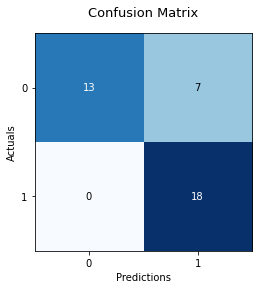

Hasil Performa (f1-score, presisi, recall, accuracy)  =  0.8112 0.8674 0.8158 0.8158

Total Data Latih II (Bin 1, Bin 2, dan Bin 3) =  261
Jumlah kelas positif data latih II =  0
Jumlah kelas negatif data latih II =  0

Hasil Bin-4


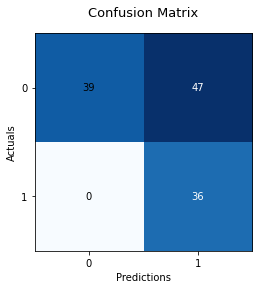

Hasil Performa (f1-score, presisi, recall, accuracy)  =  0.6184 0.8329 0.6148 0.6148

Hasil Bin-5


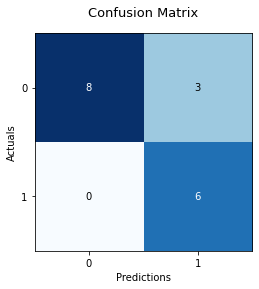

Hasil Performa (f1-score, presisi, recall, accuracy)  =  0.8272 0.8824 0.8235 0.8235

Hasil Keseluruhan Prediksi


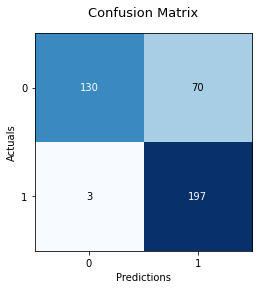

Hasil Performa (f1-score, presisi, recall, accuracy)  =  0.8122 0.8576 0.8175 0.8175

Classification Report = 
              precision    recall  f1-score   support

    negative       0.98      0.65      0.78       200
    positive       0.74      0.98      0.84       200

    accuracy                           0.82       400
   macro avg       0.86      0.82      0.81       400
weighted avg       0.86      0.82      0.81       400



In [ ]:
# menggabungkan data pada Bin 1, Bin 2 dan Bin 3
data_123 = np.concatenate((X_1,X_2,X_3), axis=None)
label_123 = np.concatenate((Z_1,Z_2,Y_3), axis=None)
# mengonversi data teks menggunakan tf_idf
data_123 = tf_idf(data_123)

# mengambil data pada Bin 1 dan Bin 2 untuk dijadikan data train pertama
jumlahBin_12 = len(X_1) + len(X_2)
X_train_1 = data_123[:jumlahBin_12]
Y_train_1 = label_123[:jumlahBin_12]
# mengambil data pada Bin 3 untuk dijadikan data test pertama
X_test_1 = data_123[jumlahBin_12:]
Y_test_1 = label_123[jumlahBin_12:]

# menghitung jumlah data pada data train pertama
jumlahTrain_1 = len(X_1) + len(X_2)
print("\nTotal Data Latih I (Bin 1 dan Bin 2) = ", jumlahTrain_1)
print("Jumlah kelas positif data latih I = ", ((Y_train_1 == 1).sum()))
print("Jumlah kelas negatif data latih I = ", ((Y_train_1 == 0).sum()))

# memprediksi ulang label pada Bin 3 menggunakan SVM
prediction_bin3 = ML_Classifier(X_train_1, Y_train_1, X_test_1)

# menampilkan hasil prediksi pada Bin 3
print("\nHasil Bin-3")
conf_matrix_bin3, precision_bin3, recall_bin3, f1score_bin3, acc_bin3 = performance_results(Y_test_1, prediction_bin3)
print("Hasil Performa (f1-score, presisi, recall, accuracy)  = ", round(f1score_bin3,4), round(precision_bin3,4),  round(recall_bin3,4),round(acc_bin3,4))

# menggabungkan data pada Bin 1, Bin 2, Bin 3, Bin 4, dan Bin 5
data_12345 = np.concatenate((X_1,X_2,X_3,X_4,X_5), axis=None)
# untuk label pada Bin 3 menggunakan hasil prediksi baru
label_12345 = np.concatenate((Z_1,Z_2,prediction_bin3,Y_4,Y_5), axis=None)
# mengonversi data teks menggunakan tf_idf
data_12345 = tf_idf(data_12345)
# menghitung jumlah data train yang diambil dari Bin 1, Bin 2, dan Bin 3
jumlahBin_123 = len(X_1) + len(X_2) + len(X_3)

# mengambil data pada Bin 1, Bin 2, dan Bin 3 untuk dijadikan data train kedua
X_train_2 = data_12345[:jumlahBin_123]
Y_train_2 = label_12345[:jumlahBin_123]
# mengambil data pada Bin 4 dan Bin 5 untuk dijadikan data test kedua
X_test_2 = data_12345[jumlahBin_123:]
Y_test_2 = label_12345[jumlahBin_123:]

# menghitung jumlah data pada data train kedua
jumlahTrain_2 = len(X_1) + len(X_2) + len(X_3)
print("\nTotal Data Latih II (Bin 1, Bin 2, dan Bin 3) = ",jumlahTrain_2)
print("Jumlah kelas positif data latih II = ", ((Y_train_2 == 1).sum()))
print("Jumlah kelas negatif data latih II = ", ((Y_train_2 == 0).sum()))

# memprediksi ulang label pada Bin 4 dan Bin 5 menggunakan SVM
prediction_bin45 = ML_Classifier(X_train_2, Y_train_2, X_test_2)

# menampilkan hasil prediksi pada Bin 4
print("\nHasil Bin-4")
conf_matrix_bin4, precision_bin4, recall_bin4, f1score_bin4, acc_bin4 = performance_results(Y_test_2[:len(X_4)], prediction_bin45[:len(X_4)])
print("Hasil Performa (f1-score, presisi, recall, accuracy)  = ", round(f1score_bin4,4), round(precision_bin4,4),  round(recall_bin4,4),round(acc_bin4,4) )

# menampilkan hasil prediksi pada Bin 5
print("\nHasil Bin-5")
conf_matrix_bin5, precision_bin5, recall_bin5, f1score_bin5, acc_bin5 = performance_results(Y_test_2[len(X_4):], prediction_bin45[len(X_4):])
print("Hasil Performa (f1-score, presisi, recall, accuracy)  = ", round(f1score_bin5,4), round(precision_bin5,4), round(recall_bin5,4), round(acc_bin5,4) )

# menggabungkan data label yang sebenarnya dari seluruh data
true_label = np.concatenate((Y_1,Y_2,Y_3,Y_4,Y_5), axis=None)
# menggabungkan hasil prediksi dari seluruh data
all_prediction = np.concatenate((Z_1,Z_2,prediction_bin3, prediction_bin45), axis=None)

# menampilkan keseluruhan hasil prediksi
print("\nHasil Keseluruhan Prediksi")
conf_matrix_all, precision_all, recall_all, f1_score_all, acc_all = performance_results(true_label, all_prediction)
print("Hasil Performa (f1-score, presisi, recall, accuracy)  = ", round(f1_score_all,4), round(precision_all,4),  round(recall_all,4), round(acc_all,4))
print("\nClassification Report = ")
print(metrics.classification_report(true_label, all_prediction))

# Perbandingan Hasil Performa

In [ ]:
all_text = np.concatenate((X_1,X_2,X_3,X_4,X_5), axis=None)
df['hasil'] = np.where((df['actual label'] == df['predicted label']), "true", "false")
data_leks = df[['data preprocessing', 'actual label', 'predicted label', 'hasil']]
data_leks = data_leks.rename(columns={'predicted label':'predicted label lexicon', 'hasil':'result lexicon'})

data_hybrid = pd.DataFrame(list(zip(all_text, true_label, all_prediction)), columns =['data preprocessing', 'actual label hybrid', 'predicted label hybrid'])
data_hybrid['result hybrid'] = np.where((data_hybrid['actual label hybrid'] == data_hybrid['predicted label hybrid']), "true", "false")

all_data = data_leks.merge(data_hybrid, how='left')
del all_data['actual label hybrid']
all_data['result desc'] = np.where((all_data['result lexicon'] == all_data['result hybrid']), "similar", "different")
all_data

,data preprocessing,actual label,predicted label lexicon,result lexicon,predicted label hybrid,result hybrid,result desc
0,tolol tidak hubung nya gugur pakai hijab syar ...,negative,negative,true,negative,true,similar
1,bodoh sekali tata cowok banget bela in balik a...,negative,negative,true,negative,true,similar
2,kemarin mewek lengket aduh kok labil banget si...,negative,negative,true,positive,false,different
3,inti kesal ayu ting ting nya tidak anak kasiha...,negative,negative,true,positive,false,different
4,aduh perempuan sakit jiwa kenapa peran utama f...,negative,positive,false,positive,false,similar
...,...,...,...,...,...,...,...
401,bangga suami istri sela waktu apa profesi kau ...,positive,positive,true,positive,true,similar
402,apa kerja penting halal u nafkah keluarga sema...,positive,positive,true,positive,true,similar
403,gojek mayoritas pegangguran lama tidak kerja p...,positive,negative,false,negative,false,similar
404,asli cantik ayu loh mbak temu langsung mbak ny...,positive,positive,true,positive,true,similar


In [ ]:
data_leks.to_excel('hasil_leksikon.xlsx', index=False)
data_hybrid.to_excel('hasil_hybrid.xlsx', index=False)
all_data.to_excel('hasil_all.xlsx', index=False)

In [ ]:
score_data = {"Evaluation": ["F1 Score", "Precision", "Recall", "Accuracy"],
              "Leksikon SentiStrength": [f1score, precision, recall, acc],
              "Leksikon SentiStrength + SVM": [f1_score_all, precision_all, recall_all, acc_all]}
df_score = pd.DataFrame(score_data)
df_score.set_index('Evaluation', inplace=True)
df_score

,Leksikon SentiStrength,Leksikon SentiStrength + SVM
Evaluation,,
F1 Score,0.765099,0.812232
Precision,0.811794,0.857636
Recall,0.772500,0.817500
Accuracy,0.772500,0.817500


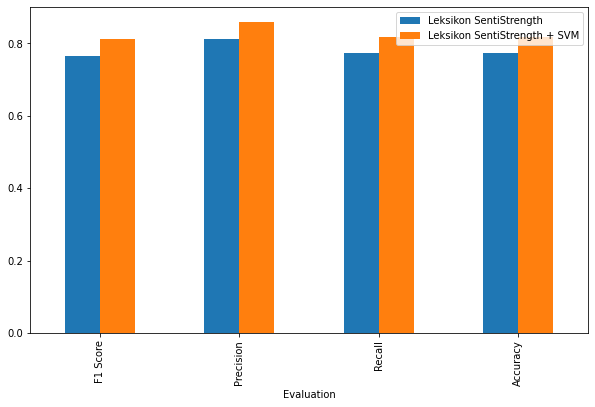

In [ ]:
df_score.plot(kind='bar', figsize=(10,6))